In [1]:
import numpy as np
import os
import cv2
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
# --- 1. Custom Loader for .sdt files (Magellan Format) ---
def load_magellan_image(filepath):
    """
    Reads a .sdt file (1024x1024 binary uint8) and returns a numpy array.
    """
    with open(filepath, 'rb') as f:
        # The format is typically 1024x1024 unsigned 8-bit integers
        img = np.fromfile(f, dtype='uint8')
        img = img.reshape((1024, 1024))
    return img

def load_labels(label_path):
    """
    Reads .lxyr files: Label, X, Y, Radius
    """
    # Adjust separation based on actual file (sometimes spaces, sometimes tabs)
    try:
        df = pd.read_csv(label_path, sep='\s+', header=None, names=['label', 'x', 'y', 'r'])
        # Filter for certainty if needed (Label 1 = Definite Volcano)
        return df
    except Exception as e:
        return pd.DataFrame(columns=['label', 'x', 'y', 'r'])

# --- 2. Create "Patch" Dataset (Manual ROI Extraction) ---
# We will extract small 64x64 chips around volcanoes (positives) and random background (negatives)
IMG_DIR = './volcanoes/package/Images/'  # Update your path
LBL_DIR = './volcanoes/package/GroundTruths/'  # Update your path
PATCH_SIZE = 64

X_data = []
y_data = []

# This loop assumes filenames like 'img1.sdt', 'img1.lxyr'
# You may need to adjust based on your exact file structure
for i in range(1, 135): # 134 images in typical JARtool set
    img_name = f"img{i}.sdt"
    lbl_name = f"img{i}.lxyr"
    img_path = os.path.join(IMG_DIR, img_name)
    lbl_path = os.path.join(LBL_DIR, lbl_name)
    
    if not os.path.exists(img_path): continue
    
    image = load_magellan_image(img_path)
    labels = load_labels(lbl_path)
    
    # Extract Positives
    for idx, row in labels.iterrows():
        cx, cy = int(row['x']), int(row['y'])
        
        # Simple bounds check
        if cx < PATCH_SIZE or cx > 1024-PATCH_SIZE or cy < PATCH_SIZE or cy > 1024-PATCH_SIZE:
            continue
            
        patch = image[cy-PATCH_SIZE//2 : cy+PATCH_SIZE//2, cx-PATCH_SIZE//2 : cx+PATCH_SIZE//2]
        X_data.append(patch)
        y_data.append(1) # 1 = Volcano

    # Extract Negatives (Random Background)
    # We take a few random patches per image to balance
    for _ in range(len(labels) + 2): 
        rx = np.random.randint(PATCH_SIZE, 1024-PATCH_SIZE)
        ry = np.random.randint(PATCH_SIZE, 1024-PATCH_SIZE)
        # ( Ideally you would check distance to known volcanoes to ensure true negative )
        patch = image[ry-PATCH_SIZE//2 : ry+PATCH_SIZE//2, rx-PATCH_SIZE//2 : rx+PATCH_SIZE//2]
        X_data.append(patch)
        y_data.append(0) # 0 = Not Volcano

X = np.array(X_data)
y = np.array(y_data)

# Normalize to 0-1
X = X / 255.0

print(f"Dataset Shape: {X.shape}, Labels: {y.shape}")

<>:18: SyntaxWarning: invalid escape sequence '\s'
<>:18: SyntaxWarning: invalid escape sequence '\s'
C:\Users\u\AppData\Local\Temp\ipykernel_4688\2038979419.py:18: SyntaxWarning: invalid escape sequence '\s'
  df = pd.read_csv(label_path, sep='\s+', header=None, names=['label', 'x', 'y', 'r'])


Dataset Shape: (3015, 64, 64), Labels: (3015,)


In [3]:
from skimage.feature import hog

# ... (Assume X_data and y_data are already loaded from the previous step) ...

# --- 1. Define HOG Feature Extractor ---
def extract_hog_features(images):
    """
    Converts (N, 64, 64) grayscale images into HOG feature vectors.
    """
    hog_features = []
    
    print("Extracting HOG features... this might take a moment.")
    
    for img in images:
        # Ensure image is 64x64
        if img.shape != (64, 64):
            img = cv2.resize(img, (64, 64))
            
        # Calculate HOG
        # orientations=9: The number of direction bins (0 to 180 degrees)
        # pixels_per_cell=(8, 8): Aggregates gradients in 8x8 pixel squares
        # cells_per_block=(2, 2): Normalizes lighting over larger areas
        features = hog(img, 
                       orientations=9, 
                       pixels_per_cell=(8, 8),
                       cells_per_block=(2, 2), 
                       block_norm='L2-Hys', 
                       visualize=False)
        
        hog_features.append(features)
        
    return np.array(hog_features)

# --- 2. Process Data ---
# X_data should be your list of 64x64 patches from Part 1
X_hog = extract_hog_features(np.array(X_data)) 

print(f"Input Image Shape: (64, 64)")
print(f"HOG Feature Vector Length: {X_hog.shape[1]}") 
# With 64x64 input and these params, vector length usually around 1764

# Split Data
X_train, X_test, y_train, y_test = train_test_split(X_hog, y_data, test_size=0.2, random_state=42)

# --- 3. Build TensorFlow Model ---
# Note: Input shape is now the length of the HOG vector, not the image dimensions
feature_vector_length = X_train.shape[1]

model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(feature_vector_length,)),
    
    # Dense layers to interpret the HOG features
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.4), # Dropout is crucial to prevent memorizing features
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    
    # Output
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train
history = model.fit(X_train, np.array(y_train), 
                    epochs=30, 
                    batch_size=32, 
                    validation_data=(X_test, np.array(y_test)))

# Save
model.save('venus_hog_model.keras')
print("Model trained and saved.")

Extracting HOG features... this might take a moment.
Input Image Shape: (64, 64)
HOG Feature Vector Length: 1764


c:\Users\u\anaconda3\envs\compvis\Lib\site-packages\keras\src\layers\core\input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 1/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.5743 - loss: 0.6872 - val_accuracy: 0.6119 - val_loss: 0.6619
Epoch 2/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.5862 - loss: 0.6776 - val_accuracy: 0.6119 - val_loss: 0.6534
Epoch 3/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.5869 - loss: 0.6721 - val_accuracy: 0.6186 - val_loss: 0.6423
Epoch 4/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.6422 - loss: 0.6479 - val_accuracy: 0.7164 - val_loss: 0.6334
Epoch 5/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.6392 - loss: 0.6328 - val_accuracy: 0.7081 - val_loss: 0.6123
Epoch 6/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.6713 - loss: 0.6253 - val_accuracy: 0.7430 - val_loss: 0.5912
Epoch 7/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.6919 - loss: 0.5980 - val_accuracy: 0.7264 - val_loss: 0.5708
Epoch 8/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.7026 - loss: 0.5765 - val_accuracy: 0.7479 - v

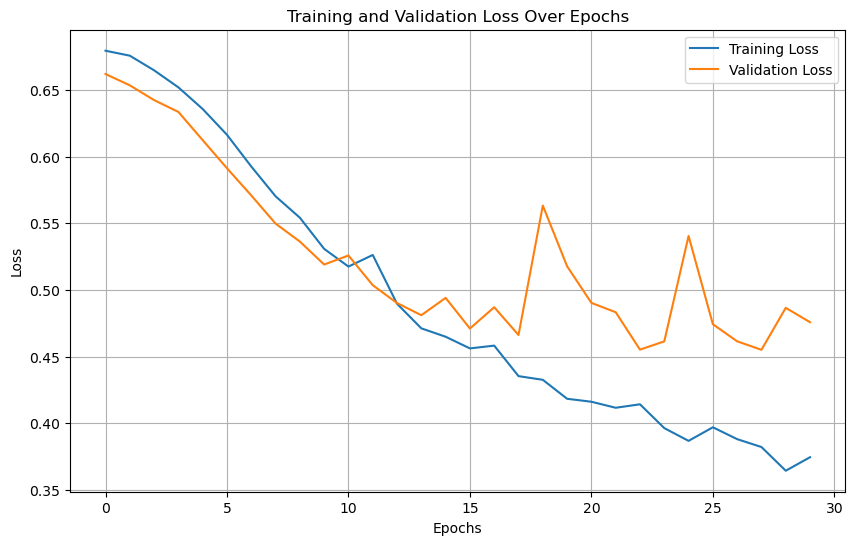

In [4]:
import matplotlib.pyplot as plt

# Assuming 'history' is the variable returned by model.fit()
# e.g., history = model.fit(...)

plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


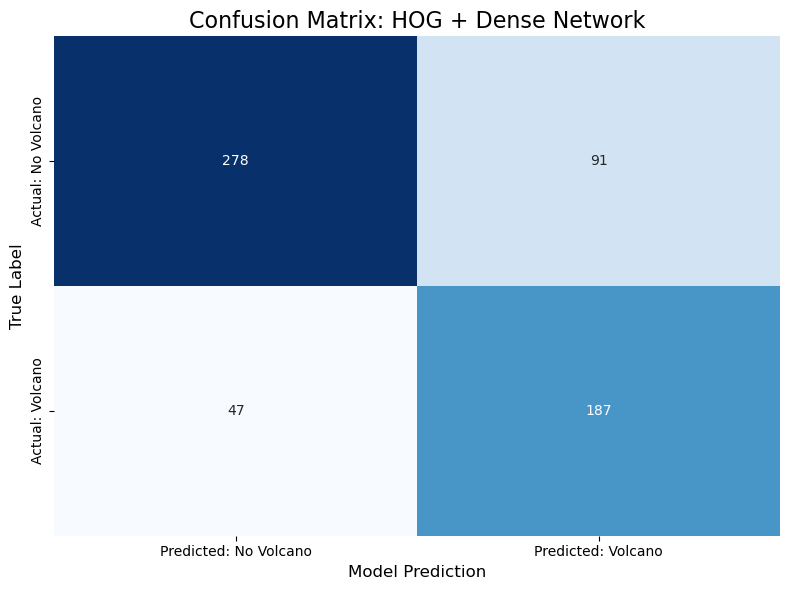


--- Classification Report ---
              precision    recall  f1-score   support

  No Volcano       0.86      0.75      0.80       369
     Volcano       0.67      0.80      0.73       234

    accuracy                           0.77       603
   macro avg       0.76      0.78      0.77       603
weighted avg       0.78      0.77      0.77       603



In [5]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

y_pred_probs = model.predict(X_test)
y_pred_classes = (y_pred_probs > 0.5).astype(int)
cm = confusion_matrix(y_test, y_pred_classes)

plt.figure(figsize=(8, 6))

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted: No Volcano', 'Predicted: Volcano'],
            yticklabels=['Actual: No Volcano', 'Actual: Volcano'])

plt.title('Confusion Matrix: HOG + Dense Network', fontsize=16)
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Model Prediction', fontsize=12)
plt.tight_layout()
plt.show()

print()
print("--- Classification Report ---")
print(classification_report(y_test, y_pred_classes, target_names=['No Volcano', 'Volcano']))

In [6]:
%%writefile app.py
import streamlit as st
import tensorflow as tf
import numpy as np
import cv2
from PIL import Image
from skimage.feature import hog
from skimage import exposure


# --- Page Config ---
st.set_page_config(page_title="Venus HOG Detector", layout="centered")

# --- Load Model ---
@st.cache_resource
def load_trained_model():
    return tf.keras.models.load_model('venus_hog_model.keras')

model = load_trained_model()

# --- HOG Extraction (Must match training exactly) ---
def process_image_hog(pil_image):
    # 1. Convert to grayscale
    img = pil_image.convert('L') 
    
    # 2. Resize to 64x64 (Critical for HOG consistency)
    img = img.resize((64, 64))
    img_array = np.array(img)
    
    # 3. Extract HOG Features
    # Note: We don't manually normalize pixel values to 0-1 here because 
    # skimage.hog handles unnormalized inputs well, but if your training
    # data was float 0-1, convert this to float 0-1 too.
    
    # Assuming training used standard 0-255 or 0-1, maintain consistency.
    # Here we perform HOG on the image directly.
    features, hog_image = hog(img_array, 
                              orientations=9, 
                              pixels_per_cell=(8, 8),
                              cells_per_block=(2, 2), 
                              block_norm='L2-Hys', 
                              visualize=True) # visualize=True gives us a cool image to show
    
    # 4. Reshape for model (1, vector_length)
    return features.reshape(1, -1), img_array, hog_image

# --- UI Layout ---
st.title("🌋 Venus Volcano Detector (HOG)")
st.markdown("""
This model uses **Histogram of Oriented Gradients (HOG)** to detect volcanoes. 
Instead of looking at raw pixels, it looks at the *direction of edges* to identify the circular rim of a volcano.
""")

uploaded_file = st.file_uploader("Upload a SAR chip", type=['png', 'jpg', 'jpeg'])

if uploaded_file is not None:
    image = Image.open(uploaded_file)
    
    col1, col2 = st.columns(2)
    
    with col1:
        st.image(image, caption='Original Image', width=200)
    
    if st.button("Analyze Pattern"):
        features, processed_img, hog_visual = process_image_hog(image)
        
        with col2:
            # Rescale HOG image for display visibility
            hog_image_rescaled = exposure.rescale_intensity(hog_visual, in_range=(0, 10))
            st.image(hog_image_rescaled, caption='Computer Vision (HOG View)', width=200, clamp=True)
            st.caption("This is what the model 'sees': edge directions.")

        # Predict
        prediction = model.predict(features)
        score = prediction[0][0]
        
        st.divider()
        
        if score > 0.5:
            st.success(f"**Volcano Detected!** (Confidence: {score:.2%})")
        else:
            st.error(f"**No Volcano Detected.** (Confidence: {1-score:.2%})")

Overwriting app.py
